# Recommendation System Project
##### [1. Word Cloud Generation with 지원동기+느낀점 / 소감+평가+전하고싶은말](#1.-Word-Cloud-Generation)
##### [2. KCluster with values from word cloud](#2.-KCluster)
##### [3. FFM Prediction](#3.-FFM)

## 1. Word Cloud Generation

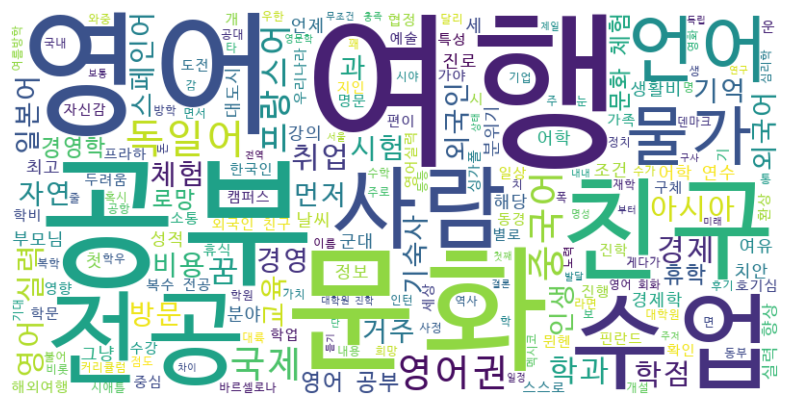

In [ ]:
from extract_helper import old_extract_motivation, new_extract_motivation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from konlpy.tag import Okt
import os

path_to_files = "data_set"
files_to_process = ["page_101_to_200.csv"]

for file_name in files_to_process:
    file_path = os.path.join(path_to_files, file_name)
    df = pd.read_csv(file_path)
    reasons = df['Attachment Content'].apply(old_extract_motivation)

    # 2. 형태소 분석기로 명사 추출
    text = ' '.join(reasons.dropna())  # 모든 텍스트를 결합

    okt = Okt()  # Okt 형태소 분석기 생성
    nouns = okt.nouns(text)  # 명사만 추출

    # 3. 명사 리스트를 하나의 문자열로 변환
    cleaned_text = ' '.join(nouns)

    stopwords = set()
    with open("stopwords.txt", 'r', encoding='utf-8') as file:
        for line in file:
            words = line.split()  # 기본적으로 공백을 기준으로 split
            stopwords.update(words)  # set에 words 추가 (중복 제거)

    # 4. WordCloud 객체 생성
    font_path = "/Users/gayeonlee/Library/Fonts/D2Coding-Ver1.3.2-20180524.ttc"
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path, stopwords=stopwords).generate(cleaned_text)

    # 5. 워드 클라우드 표시
    plt.figure(figsize=(10, 5))
    plt.rc('font', family='NanumGothicOTF')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # 축 제거
    plt.show()

